Source: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [268]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_regression
from collections import defaultdict
import missingno as msno


In [269]:
df = pd.read_csv("Data/county_data_clean.csv").drop(columns="Unnamed: 0")
df = df[df.state_abbreviation!='US']

In [290]:
non_normalized_columns = []

for column in df.columns:
    if column not in ['state_fips_code','county_fips_code','5_digit_fips_code', 'state_abbreviation','name']:
        if (df[column].values > 1.0).any():
            non_normalized_columns.append(column)


non_normalized_columns

['premature_death',
 'premature_death_black',
 'premature_death_hispanic',
 'premature_death_white',
 'poor_physical_health_days',
 'poor_mental_health_days',
 'food_environment_index',
 'sexually_transmitted_infections',
 'teen_births',
 'teen_births_black',
 'teen_births_hispanic',
 'teen_births_white',
 'ratio_of_population_to_primary_care_physicians',
 'ratio_of_population_to_dentists',
 'ratio_of_population_to_mental_health_providers',
 'preventable_hospital_stays',
 'preventable_hospital_stays_black',
 'preventable_hospital_stays_hispanic',
 'preventable_hospital_stays_white',
 'income_inequality',
 'social_associations',
 'violent_crime',
 'injury_deaths',
 'air_pollution__particulate_matter',
 'life_expectancy',
 'life_expectancy_black',
 'life_expectancy_hispanic',
 'life_expectancy_white',
 'premature_age_adjusted_mortality',
 'premature_age_adjusted_mortality_black',
 'premature_age_adjusted_mortality_hispanic',
 'premature_age_adjusted_mortality_white',
 'child_mortality',


In [244]:
features_df = df.drop(['uninsured_adults', 'uninsured_children', 'county_fips_code',
                   '5_digit_fips_code'], axis = 1)
# Replacing missing value of uninsured with mean of uninsured
features_df['uninsured'] = features_df.uninsured.replace([float("nan")], features_df.uninsured.mean())

for column in features_df.columns:
    na_sum= (features_df[column].isna().sum())
    column_size = (features_df[column].size)
    #print(na_sum/column_size)
    if (features_df[column].isna().sum()/features_df[column].size) > 0.25:
        features_df = features_df.drop(columns=column)
features_df.shape

(3193, 77)

In [245]:
state_groupby = features_df.groupby('state_abbreviation').count()

In [246]:
state_groupby = features_df.groupby('state_abbreviation').count()
null_count_dict = defaultdict(int)

for column in state_groupby.columns:
    null_count_dict[column] = 0
    for state in state_groupby.index:
        value = state_groupby.loc[state][column]
        size = state_groupby.loc[state]['state_fips_code']
        if (value/size) <= 0.25:
            print("{0} is not useful for {1}: {2}".format(column, state, str(value/size)))
            null_count_dict[column] += 1
            
exclude_features = []
for feature, null_count in null_count_dict.items():
    if null_count > 13:
        exclude_features.append(feature.strip(""))

air_pollution__particulate_matter is not useful for AK: 0.0
air_pollution__particulate_matter is not useful for HI: 0.0
drinking_water_violations is not useful for HI: 0.0
hiv_prevalence is not useful for ND: 0.24074074074074073
hiv_prevalence is not useful for NE: 0.13829787234042554
hiv_prevalence is not useful for SD: 0.014925373134328358
children_eligible_for_free_or_reduced_price_lunch is not useful for DC: 0.0
children_eligible_for_free_or_reduced_price_lunch is not useful for DE: 0.0
children_eligible_for_free_or_reduced_price_lunch is not useful for MA: 0.0
children_eligible_for_free_or_reduced_price_lunch is not useful for TN: 0.0


In [247]:
features_df = features_df.drop(columns = exclude_features)

In [248]:
# Drop indices that has more than 25% data
exclude_indices = []
for index in features_df.index:
    series = features_df.drop(columns=['state_fips_code', 'state_abbreviation', 'name']).loc[index]
    null_count = len(series[series.isnull()])
    series_size = len(series)
    if (null_count/series_size) >= 0.25:
        exclude_indices.append(index)

features_df = features_df.drop(index=exclude_indices)

<AxesSubplot:>

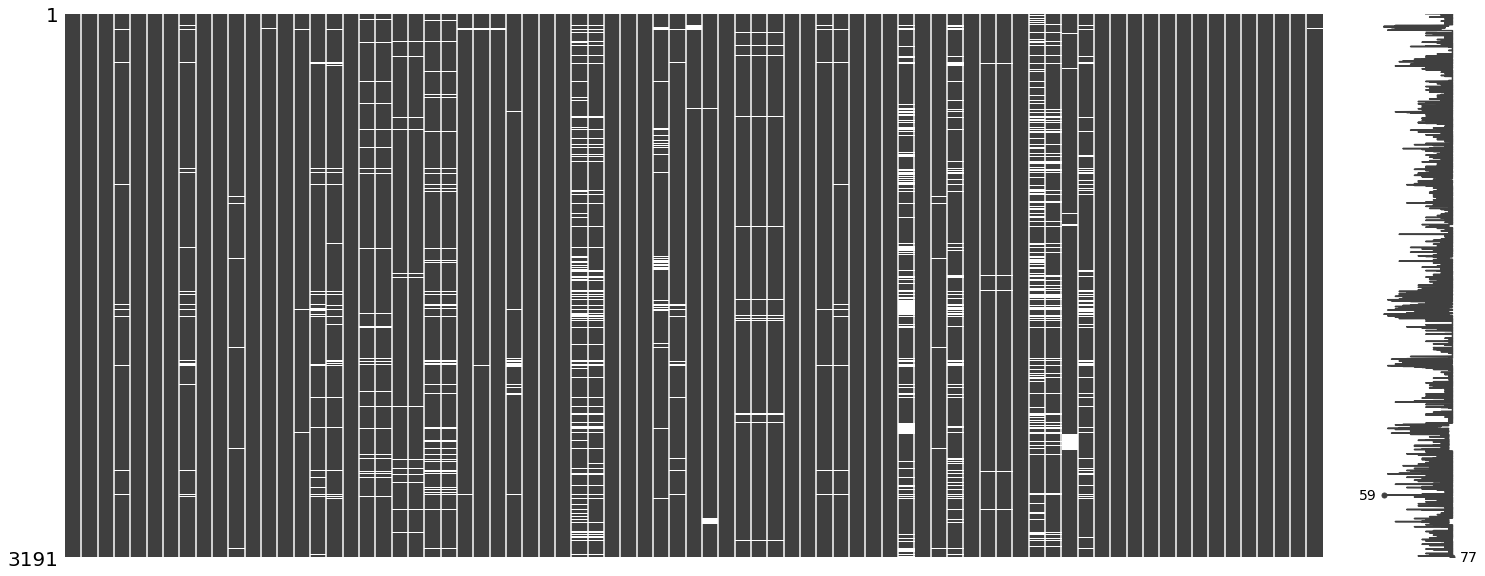

In [249]:
# Illustrate missing data
msno.matrix(features_df)

In [250]:
features = features_df.drop(['uninsured','state_fips_code','state_abbreviation', 'name'], axis = 1)
features_list = features_df.drop(['uninsured','state_fips_code', 'state_abbreviation'], axis = 1).columns.to_list()
imp = SimpleImputer()
features = imp.fit_transform(features)

labels = np.array(features_df['uninsured'])




In [251]:
"""
# Computing Variance Inflation Factors
sub_df = pd.DataFrame(data=features, columns=features_list)
vif_data_copy = sub_df.copy()


while not vif_data_copy.empty:
    print("entered")
    interesting_vars = sub_df.columns.to_list()
    X = sub_df[interesting_vars]

    # VIF dataframe
    print("entered again")
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns

    # calculating VIF for each feature
    
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]

    print(vif_data)

    if float('inf') in vif_data["VIF"].unique():
        feature_list = vif_data[vif_data['VIF']==float("inf")].feature.to_list()
        sub_df = sub_df.drop(columns=feature_list[0])
        vif_data_copy = vif_data[vif_data.feature!= feature_list[0]]
    elif ~ vif_data[vif_data['VIF'] >= 5].empty:
        feature_list = vif_data[vif_data['VIF']>= 5].feature.to_list()
        sub_df = sub_df.drop(columns=feature_list[0])
        vif_data_copy = vif_data[vif_data.feature!= feature_list[0]]
    else:
        vif_data_copy = pd.DataFrame()

sub_df
"""

'\n# Computing Variance Inflation Factors\nsub_df = pd.DataFrame(data=features, columns=features_list)\nvif_data_copy = sub_df.copy()\n\n\nwhile not vif_data_copy.empty:\n    print("entered")\n    interesting_vars = sub_df.columns.to_list()\n    X = sub_df[interesting_vars]\n\n    # VIF dataframe\n    print("entered again")\n    vif_data = pd.DataFrame()\n    vif_data["feature"] = X.columns\n\n    # calculating VIF for each feature\n    \n    vif_data["VIF"] = [variance_inflation_factor(X.values, i)\n                              for i in range(len(X.columns))]\n\n    print(vif_data)\n\n    if float(\'inf\') in vif_data["VIF"].unique():\n        feature_list = vif_data[vif_data[\'VIF\']==float("inf")].feature.to_list()\n        sub_df = sub_df.drop(columns=feature_list[0])\n        vif_data_copy = vif_data[vif_data.feature!= feature_list[0]]\n    elif ~ vif_data[vif_data[\'VIF\'] >= 5].empty:\n        feature_list = vif_data[vif_data[\'VIF\']>= 5].feature.to_list()\n        sub_df = su

In [252]:
train_features, test_features, train_labels, test_labels = \
train_test_split(features, labels, test_size = 0.20, random_state = 42, stratify=features_df.state_abbreviation)


In [253]:
# Random forest regressor
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(train_features, train_labels)

RandomForestRegressor(random_state=42)

In [254]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'percent.')

Mean Absolute Error: 0.02 percent.


In [255]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 82.08 %.


In [257]:
name = features[:, features_list.index('name')]
test_name = test_features[:, features_list.index('name')]


# Dataframe with true values
true_data = pd.DataFrame(data = {'county_name': test_name, 'actual': test_labels})
true_data.actual = true_data.actual.apply(lambda x: x * 100.0)

# Dataframe with predictions
predictions_data = pd.DataFrame(data = {'county_name': test_name, 'prediction': predictions})
predictions_data.prediction = predictions_data.prediction.apply(lambda x: x * 100.0)

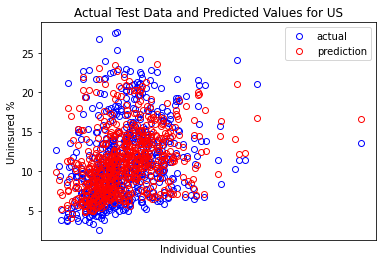

In [263]:
# Plot the actual values
plt.plot(true_data['county_name'], true_data['actual'], 'bo', label = 'actual', markerfacecolor='none')
# Plot the predicted values
plt.plot(predictions_data['county_name'], predictions_data['prediction'], 'ro', label = 'prediction',
        markerfacecolor='none')

plt.xticks([]); 
plt.legend()
# Graph labels
plt.xlabel('Individual Counties'); plt.ylabel('Uninsured %'); plt.title('Actual Test Data and Predicted Values for {}'.format('US'))
plt.savefig("Data/Random_Forest_Results/Predictions_Scatter/us_actual_predictions_scatter.png")

Source: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [259]:
importances = rf.feature_importances_
importances

array([0.00252729, 0.00877359, 0.0030356 , 0.00968133, 0.00444781,
       0.00466092, 0.00917535, 0.00606539, 0.0112568 , 0.00587565,
       0.06535778, 0.00445425, 0.00364358, 0.00673201, 0.00191305,
       0.0022649 , 0.00341597, 0.00341308, 0.00995551, 0.04081861,
       0.00429273, 0.00952847, 0.00269111, 0.0106353 , 0.04481601,
       0.01154739, 0.00527985, 0.00248883, 0.0034335 , 0.00352118,
       0.00375075, 0.004025  , 0.00655897, 0.00413513, 0.01054916,
       0.0005984 , 0.00332118, 0.00710908, 0.0171135 , 0.00552163,
       0.01383054, 0.00393575, 0.00319264, 0.00264881, 0.00293808,
       0.00321311, 0.00378906, 0.00296906, 0.01056489, 0.00386405,
       0.06443705, 0.03681427, 0.00180342, 0.00278543, 0.00631579,
       0.0035375 , 0.00377174, 0.05669221, 0.00341321, 0.00351542,
       0.00439914, 0.01190426, 0.00940821, 0.00788452, 0.01535558,
       0.04281897, 0.0052556 , 0.00425384, 0.02190234, 0.21858285,
       0.0436682 , 0.00378759, 0.00836123])

In [260]:
features_list.remove('name')

In [261]:
forest_importances = pd.Series(importances, index=features_list)
forest_importances = forest_importances.sort_values(ascending=False).head(10)
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances

%_non_hispanic_white                                 0.218583
excessive_drinking                                   0.065358
motor_vehicle_crash_deaths                           0.064437
children_eligible_for_free_or_reduced_price_lunch    0.056692
some_college                                         0.044816
%_not_proficient_in_english                          0.043668
%_american_indian_and_alaskan_native                 0.042819
ratio_of_population_to_mental_health_providers       0.040819
insufficient_sleep                                   0.036814
%_hispanic                                           0.021902
dtype: float64

<ipython-input-262-ac285af466c6>:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


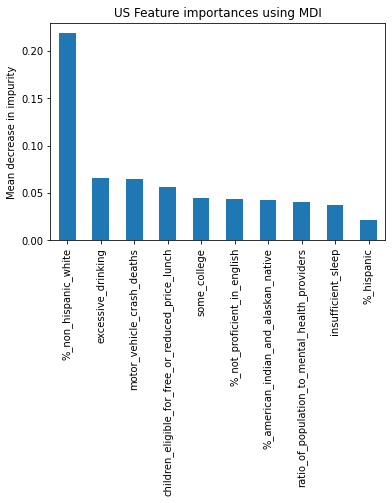

In [262]:
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("US Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig('Data/Random_Forest_Results/Feature_Importance/us_feature_importance_bar.png')